# MULTIGRIS ISM applications
## Estimate number of components required (SFGX context)

<font color=red>For best performance, it is advised to execute MULTIGRIS in the shell, as explained in the README. This notebook is just a way to illustrate a workflow. </font>

***
This notebook presents some examples of ISM applications with MULTIGRIS. <font color=red>Make sure to check the general notebooks on how to run the programs beforehand!</font>

We'll also take the occasion to use various plots and inference options. 

The applications will use the following Cloudy grid (Ferland et al. [2017](https://ui.adsabs.harvard.edu/abs/2017RMxAA..53..385F/abstract)):
- SFGX (star-forming galaxies with X-ray component; Ramambason et al. [2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..35R/abstract))

The various notebooks use some specific terms described in the file TERMS.org. 
***

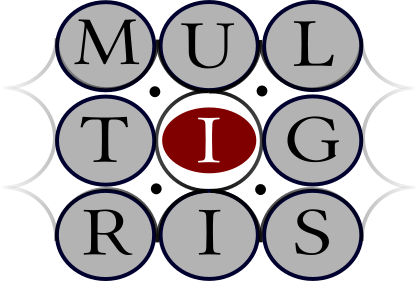

In [1]:
%load_ext autoreload
%autoreload 2
from wand.image import Image as WImage #this is to view PDFs
from IPython.display import Image
Image(filename='../Images/logo.png')

## Table of contents:
* [Estimate number of components required](#app6)
  * [Running models with different number of components and compare afterwards](#app6a)
  * [Running a model with n sectors and estimate whether some sectors can be ignored](#app6b)
  * [Full comparison](#app6c)

## Imports and settings
***

In [2]:
import os 

import sys
sys.path.append('../') 

#arviz to read the PyMC3 trace
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

#imports to make input files
import importlib
import Library.lib_input
importlib.reload(Library.lib_input)
from Library.lib_input import *

#import the main MULTIGRIS scripts
import mgris_search, mgris_process, mgris_post_process, mgris_compare

#may need to run this if the script is interrupted
from Library.lib_main import closelogfiles

# global parameters
from rcparams import rcParams

#to read the grid
import pandas as pd

#this is the input filename we'll use throughout, it will be automatically copied in the output directories each run
os.makedirs('./Runs/ISM_applications', exist_ok=True)
inputfile = './Runs/ISM_applications/input.txt' 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
if rcParams['inference_backend']=='gpu':
    import jax
    jax.clear_caches()

Checking path in case several copies exist

In [4]:
mgris_search.__file__

'/local/home/vleboute/work/MULTIGRIS/mgris/mgris_search.py'

## Estimate minimum number of components required <a class="anchor" id="app6"></a>
***

The number of components in MULTIGRIS has to be set explicitly. To estimate how many components are required, you can:
- Run several models with a different number of components and compare their likelihood afterwards. 
- Try and estimate whether a lower number of components results in a higher likelihood on-the-fly, during inference.

For these tests we use the grid itself as a solution because we cannot compare models of real observations to other, independent, measurements of the number of sectors since the latter is not a standard parameter. 

We first get the observed fluxes for a set of given parameters

In [5]:
grid = pd.read_feather('../Contexts/mgris_sfgx/Grids/model_grid.fth').astype(np.float32)
params_name = ['age', 'n', 'u', 'Z', 'Lx', 'Tx', 'cut', 'lum', 'Z_dust']

#list of lines for which we wanna get the fluxes
lines = ['C2157.636m', 'O388.3323m', 'O163.1679m', 'N2205.244m', 'O1145.495m', 'Ne212.8101m', 'Ne315.5509m', 'N357.3238m', 'Ar26.98337m', 'Ar38.98898m', 'H217.0300m', 'Si234.8046m']

#required parameter set values, same order as params_name
models = [[0.477, 2, -2, -1.19, -2, 6, 2, 9, 0], ]

#mixing weight, 1 because single parameter set
ws = [1,]

#now we get the right row in the grid and get the fluxes
tmp = pd.DataFrame(models[0]).transpose().astype(np.float32)
tmp.columns = params_name
# tmp2 = pd.merge(tmp.astype(np.float32), grid.astype(np.float32), on=params_name, how='outer').iloc[0]
r = np.prod([grid[p]==tmp[p].iloc[0] for p in params_name], axis=0)
tmp2 = grid.loc[r==1].iloc[0]
obsfluxes = tmp2[lines].values

del grid

for i,o in enumerate(obsfluxes):
    print(lines[i], o)

C2157.636m 39.387
O388.3323m 39.761
O163.1679m 39.933
N2205.244m 36.187
O1145.495m 39.225
Ne212.8101m 38.087
Ne315.5509m 39.389
N357.3238m 38.556
Ar26.98337m 37.102
Ar38.98898m 38.548
H217.0300m 38.204
Si234.8046m 39.741


Let's add some noise to avoid getting a "perfect" solution in all cases

In [6]:
np.random.seed(79)

obsfluxes += np.random.normal(0, 0.02, len(obsfluxes))

for i,o in enumerate(obsfluxes):
    print(lines[i], o)

C2157.636m 39.320675
O388.3323m 39.76239
O163.1679m 39.909187
N2205.244m 36.187054
O1145.495m 39.21415
Ne212.8101m 38.106453
Ne315.5509m 39.401417
N357.3238m 38.567
Ar26.98337m 37.119106
Ar38.98898m 38.559277
H217.0300m 38.20352
Si234.8046m 39.770206


### First method: running models with different number of components and compare afterwards <a class="anchor" id="app6a"></a>

We first run models with 1 and 2 components. 

Note that this method is meaningful only if both models have converged (i.e., all chains passed the burn-in phase, converged toward the same maximum likelihood solution, and have had time to sample other potential lower-probability peaks) and if there are significantly more observations than parameters. The result provided with this method is merely informative and should be used with caution. 

In [7]:
params = get_params()
params['context'].value = 'Contexts/mgris_sfgx'
output_directory = './Runs/ISM_applications/ncomps1/'
params['output'].value = output_directory
params['USE configuration'].value = '1C1S'
params['select'].value = ['cut [2,2]', 'lum [9,9]', 'Z_dust [0,0]'] 
params['BEGIN observations'].value = '''{}'''.format('\n'.join([lines[i]+' '+str(o) for i,o in enumerate(obsfluxes)]))
params['BEGIN observations'].extras = {'delta_ref': 0.1, 'scale': 'log'}
params['use_scaling'].value = "'all'"
make_input(params, inputfile)

In [8]:
if rcParams['inference_backend']=='gpu':
    nsamples_per_job = 150
else:
    nsamples_per_job = 500
    
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, order=0, nsamples_per_job=nsamples_per_job))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C1S

    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - 1a38371 (2024-09-06 08:20:37 +0200)
    ┝ - 1a38371
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15 
    ┝========================================
    ┝ PyMC version  : 5.16.2
    ┝ Tensor library: pytensor
    ┝ - Compile directory:
    ┝   - /tmp/pytensor.NOBACKUP
    ┝ - Precision: float32
    ┕=============

[12  8  5  5  8  4  4]
-> [12  1  5  5  8  4  4]
[12  1  5  5  8  4  4]


u 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  5  8  4  4]
[12  1  1  5  8  4  4]


Z 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  8  4  4]
[12  1  1  1  8  4  4]


Lx 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  4  4]
[12  1  1  1  1  4  4]


Tx 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  4]
[12  1  1  1  1  1  4]
-> [12  1  1  1  1  1  1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_n_0, idx_u_0, scale]
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_n_0, idx_u_0, scale]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
idx_Lx_0         1.468  0.807   0.022    2.735      0.037    0.027     481.0   
idx_Tx_0         1.479  0.806   0.215    2.973      0.035    0.025     521.0   
idx_Z_0          3.434  1.898   0.455    6.882      0.096    0.068     336.0   
idx_age_0        3.438  1.856   0.231    6.554      0.079    0.056     562.0   
idx_n_0          2.023  1.044   0.310    3.798      0.054    0.040     380.0   
idx_u_0          2.003  1.049   0.171    3.731      0.048    0.034     471.0   
log_likelihood    -inf    NaN    -inf -146.686        NaN      NaN     455.0   
log_likelihood0   -inf    Na


✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨
Inference ended     : 2024-09-06 20:15:31.182580
Time used           : 0.8 min.
Sampling time used  :  0.46 min.
Garbage collection thresholds : (700, 10, 10)
Garbage collector: collected 627135 objects.

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ RESULTS AND VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
idx_Lx_0                1.956  0.318   1.512    2.462      0.008    0.005   
idx_Tx_0                1.959  0.310   1.502    2.447      0.007    0.005   
idx_Z_0                 2.008  0.280   1.526    2.445      0.006    0.005   
idx_age_0               2.170  0.851   0.642    3.478      0.019    0.013   
idx_n_0                 1.997  0.278   1.510    2.422      0.

In [9]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C1S







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 20:15:33
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/ISM_applications/input.txt
    ┝ - output directory   : ./Runs/ISM_applications/ncomps1/
    ┕========================================┙
    
List

In [10]:
%cat $output_directory/results.txt


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
idx_Lx_0   1.957  0.309   1.512    2.452      0.010    0.007     991.0     748.0   1.00
idx_Tx_0   1.961  0.308   1.503    2.438      0.009    0.007    1076.0     977.0   1.01
idx_Z_0    2.014  0.278   1.526    2.447      0.009    0.006     977.0     827.0   1.01
idx_age_0  2.171  0.863   0.630    3.450      0.028    0.020     953.0     955.0   1.00
idx_n_0    2.004  0.273   1.538    2.448      0.008    0.006    1053.0     904.0   1.00
idx_u_0    1.993  0.280   1.514    2.432      0.009    0.006    1039.0    1017.0   1.00
scale     -0.673  0.048  -0.768   -0.591      0.002    0.001     920.0    1032.0   1.00
w[0]       1.000  0.000   1.000    1.000      0.000    0.000    1000.0    1000.0    NaN
scale_eff  0.004  0.048  -0.092    0.086      0.002    0.001     920.0    1032.0   1.00

/!\ Values can be =0 if ~0
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat


with 2 components

In [11]:
params = get_params()
params['context'].value = 'Contexts/mgris_sfgx'
output_directory = './Runs/ISM_applications/ncomps2/'
params['output'].value = output_directory
params['USE configuration'].value = '1C2S'
params['select'].value = ['cut [2,2]', 'lum [9,9]', 'Z_dust [0,0]'] 
params['BEGIN observations'].value = '''{}'''.format('\n'.join([lines[i]+' '+str(o) for i,o in enumerate(obsfluxes)]))
params['BEGIN observations'].extras = {'delta_ref': 0.1, 'scale': 'log'}
params['use_scaling'].value = "'all'"
make_input(params, inputfile)

In [12]:
if rcParams['inference_backend']=='gpu':
    nsamples_per_job = 150
else:
    nsamples_per_job = 200
    
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, order=0, nsamples_per_job=nsamples_per_job))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S

    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - 1a38371 (2024-09-06 08:20:37 +0200)
    ┝ - 1a38371
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15 
    ┝========================================
    ┝ PyMC version  : 5.16.2
    ┝ Tensor library: pytensor
    ┝ - Compile directory:
    ┝   - /tmp/pytensor.NOBACKUP
    ┝ - Precision: float32
    ┕=============

[12  8  5  5  8  4  4]
-> [12  1  5  5  8  4  4]
[12  1  5  5  8  4  4]
-> [12  1  1  5  8  4  4]


Z 0: single value (nearest neighbor grid interpolation)


[12  1  1  5  8  4  4]
-> [12  1  1  1  8  4  4]


Lx 0: single value (nearest neighbor grid interpolation)


[12  1  1  1  8  4  4]
-> [12  1  1  1  1  4  4]
[12  1  1  1  1  4  4]


Tx 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  4]
[12  1  1  1  1  1  4]


age 1: single value (nearest neighbor grid interpolation)
n 1: single value (nearest neighbor grid interpolation)
u 1: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  1]
[12  8  5  5  8  4  4]
-> [12  1  5  5  8  4  4]
[12  1  5  5  8  4  4]
-> [12  1  1  5  8  4  4]


Z 1: single value (nearest neighbor grid interpolation)


[12  1  1  5  8  4  4]
-> [12  1  1  1  8  4  4]


Lx 1: single value (nearest neighbor grid interpolation)


[12  1  1  1  8  4  4]
-> [12  1  1  1  1  4  4]
[12  1  1  1  1  4  4]


Tx 1: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  4]
[12  1  1  1  1  1  4]
-> [12  1  1  1  1  1  1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, scale, w]
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, scale, w]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
idx_Lx_0         1.511  0.836   0.080    2.830      0.039    0.029     459.0   
idx_Lx_1         1.511  0.836   0.080    2.830      0.039    0.029     459.0   
idx_Tx_0         1.525  0.824   0.115    2.843      0.037    0.026     513.0   
idx_Tx_1         1.525  0.824   0.115    2.843      0.037    0.026     513.0   
idx_Z_0          3.631  1.844   0.580    6.852      0.081    0.057     519.0   
idx_Z_1          3.631  1.844   0.580    6.852      0.081    0.057     519.0   
idx_age_0        3.575  1.859   0.758    6.928      0.099    0.070

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details

✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨
Inference ended     : 2024-09-06 20:16:42.485122
Time used           : 0.7 min.
Sampling time used  :  0.38 min.
Garbage collection thresholds : (700, 10, 10)
Garbage collector: collected 1035160 objects.

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ RESULTS AND VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
idx_Lx_0                1.

In [13]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 20:16:44
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/ISM_applications/input.txt
    ┝ - output directory   : ./Runs/ISM_applications/ncomps2/
    ┕========================================┙
    
List

In [14]:
%cat $output_directory/results.txt


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
idx_Lx_0   1.939  0.321   1.501    2.460      0.017    0.012     367.0     274.0   1.00
idx_Lx_1   1.939  0.321   1.501    2.460      0.017    0.012     367.0     274.0   1.00
idx_Tx_0   1.946  0.317   1.513    2.462      0.016    0.011     422.0     375.0   1.00
idx_Tx_1   1.946  0.317   1.513    2.462      0.016    0.011     422.0     375.0   1.00
idx_Z_0    1.997  0.270   1.579    2.485      0.013    0.009     447.0     415.0   1.00
idx_Z_1    1.997  0.270   1.579    2.485      0.013    0.009     447.0     415.0   1.00
idx_age_0  2.065  0.795   0.696    3.495      0.038    0.027     442.0     267.0   1.00
idx_age_1  2.065  0.795   0.696    3.495      0.038    0.027     442.0     267.0   1.00
idx_n_0    1.976  0.274   1.516    2.431      0.013    0.010     415.0     341.0   1.01
idx_n_1    2.186  0.390   1.502    2.885      0.020    0.014     378.0     384.0   1.00
idx_u_0    2.013  0.282   1.583

Now we do the comparison. Since both models have converged for all chains (low rhat, no autocorrelation), this comparison is meaningful although we do consider a relatively small number of observations. 

You can use the program mgris_compare that just requires 2 or more models to compare as arguments. Here we just extract some code from the program:

In [15]:
closelogfiles() #in case run was interrupted
mgris_compare.main(args=mgris_compare.args(result_directories=['./Runs/ISM_applications/ncomps1/', './Runs/ISM_applications/ncomps2/']))

/!\ Model comparison is only meaningful if:
- the data is the same and observations defined the same way between the two models
- all chains have passed the burn-in phase and have converged (toward the same solution)
- there are significantly more observations than parameters

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ ./RUNS/ISM_APPLICATIONS/NCOMPS1 ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


Computed from 1000 posterior samples and 12 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -1.82     0.34
p_loo        0.62        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)        9   75.0%
   (0.67, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    3   25.0%

Computed from 1000 posterior samples and 12 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    -1.73     0.32
p_waic        0.53        -

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

The comparison based on LOO (preferred) suggests that the model with 1 component is more likely (1-3: anecdotal; 3-10: moderate; 10-30: strong; 30-100: very strong; > 100: extreme). Note that we may get a different answer if fewer lines are considered, in which case the LOO calculation may not be reliable anymore. 

If the models are not far from each other, it might be useful to combine the average the model predictions based on the weight. 

Here's a plot showing various metrics.

If you have issues with WImage on Linux, try adding ```<policy domain="coder" rights="read | write" pattern="PDF" />``` in /etc/ImageMagick-?/policy.xml

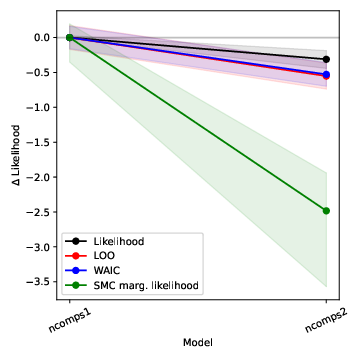

In [16]:
WImage(filename='ModelComparison/comp_ncomps1_ncomps2.pdf') 

### Second method: running a model with n sectors and estimate whether some sectors can be ignored <a class="anchor" id="app6b"></a>

For this test we would like to know the minimum number of components required when running a model with n sectors. We will run a model with 2 components for a set of observed values drawn from the grid, so in reality corresponding to a single component. The difference with the first method is that we introduce a new random variable in the model that switches on/off n-1 sectors in the model during inference. Although the mixing weights are allowed to vary and reach 0 for some components, the model may consider two or more almost identical components with mixing weights significantly larger than 0. This new random variable forces the code to consider the likelihood of solutions with n-1 sectors being ignored. 

The advantage of the second method is that we are not comparing two separate models that may have not converged. The inconvenient of the second method is that we introduce a new random variable and that the model keeps switching between discrete solutions, so it is advised to run it simply to estimate potential values for ncomps and then run independent models. Another inconvenient is that the second method is really adapted only in cases when the potential additional sectors do not change significantly the properties of the other sectors in order to prevent erratic jumps during inference. 

In [17]:
params = get_params()
params['context'].value = 'Contexts/mgris_sfgx'
output_directory = './Runs/ISM_applications/ncompsfree/'
params['output'].value = output_directory
params['USE configuration'].value = '1C2S'
params['select'].value = ['cut [2,2]', 'lum [9,9]', 'Z_dust [0,0]'] 
params['BEGIN observations'].value = '''{}'''.format('\n'.join([lines[i]+' '+str(o) for i,o in enumerate(obsfluxes)]))
params['BEGIN observations'].extras = {'delta_ref': 0.1, 'scale': 'log'}
params['BEGIN configuration'].value = '''n_comps_vary True'''
params['use_scaling'].value = "'all'"
make_input(params, inputfile)

In [18]:
if rcParams['inference_backend']=='gpu':
    nsamples_per_job = 150
else:
    nsamples_per_job = 200
    
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, order=0, nsamples_per_job=nsamples_per_job))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S

    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - 1a38371 (2024-09-06 08:20:37 +0200)
    ┝ - 1a38371
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15 
    ┝========================================
    ┝ PyMC version  : 5.16.2
    ┝ Tensor library: pytensor
    ┝ - Compile directory:
    ┝   - /tmp/pytensor.NOBACKUP
    ┝ - Precision: float32
    ┕=============

[12  8  5  5  8  4  4]
-> [12  1  5  5  8  4  4]
[12  1  5  5  8  4  4]
-> [12  1  1  5  8  4  4]


Z 0: single value (nearest neighbor grid interpolation)


[12  1  1  5  8  4  4]
-> [12  1  1  1  8  4  4]


Lx 0: single value (nearest neighbor grid interpolation)


[12  1  1  1  8  4  4]
-> [12  1  1  1  1  4  4]
[12  1  1  1  1  4  4]


Tx 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  4]
[12  1  1  1  1  1  4]


age 1: single value (nearest neighbor grid interpolation)
n 1: single value (nearest neighbor grid interpolation)
u 1: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  1]
[12  8  5  5  8  4  4]
-> [12  1  5  5  8  4  4]
[12  1  5  5  8  4  4]
-> [12  1  1  5  8  4  4]


Z 1: single value (nearest neighbor grid interpolation)


[12  1  1  5  8  4  4]
-> [12  1  1  1  8  4  4]


Lx 1: single value (nearest neighbor grid interpolation)


[12  1  1  1  8  4  4]
-> [12  1  1  1  1  4  4]
[12  1  1  1  1  4  4]


Tx 1: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  4]
[12  1  1  1  1  1  4]
-> [12  1  1  1  1  1  1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, ncomps, scale, w2]
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, ncomps, scale, w2]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
idx_Lx_0         1.542  0.829   0.211    2.936      0.040    0.028     431.0   
idx_Lx_1         1.542  0.829   0.211    2.936      0.040    0.028     431.0   
idx_Tx_0         1.457  0.823   0.225    2.990      0.035    0.025     563.0   
idx_Tx_1         1.457  0.823   0.225    2.990      0.035    0.025     563.0   
idx_Z_0          3.443  1.912   0.213    6.459      0.085    0.060     490.0   
idx_Z_1          3.443  1.912   0.213    6.459      0.085    0.060     490.0   
idx_age_0        3.541  1.947   0.280    6.662  


✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨
Inference ended     : 2024-09-06 20:18:00.907017
Time used           : 0.7 min.
Sampling time used  :  0.42 min.
Garbage collection thresholds : (700, 10, 10)
Garbage collector: collected 1047968 objects.

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ RESULTS AND VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
idx_Lx_0                1.962  0.307   1.502    2.448      0.011    0.008   
idx_Lx_1                1.962  0.307   1.502    2.448      0.011    0.008   
idx_Tx_0                1.980  0.307   1.547    2.500      0.012    0.008   
idx_Tx_1                1.980  0.307   1.547    2.500      0.012    0.008   
idx_Z_0                 2.024  0.275   1.527    2.442      0

In [19]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 20:18:03
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/ISM_applications/input.txt
    ┝ - output directory   : ./Runs/ISM_applications/ncompsfree/
    ┕========================================┙
    
L

In [20]:
%cat $output_directory/results.txt


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
idx_Lx_0   1.981  0.305   1.554    2.488      0.015    0.011     410.0     376.0   1.00
idx_Lx_1   1.981  0.305   1.554    2.488      0.015    0.011     410.0     376.0   1.00
idx_Tx_0   1.986  0.300   1.547    2.498      0.016    0.011     379.0     368.0   1.01
idx_Tx_1   1.986  0.300   1.547    2.498      0.016    0.011     379.0     368.0   1.01
idx_Z_0    2.036  0.277   1.527    2.439      0.014    0.010     419.0     372.0   1.01
idx_Z_1    2.036  0.277   1.527    2.439      0.014    0.010     419.0     372.0   1.01
idx_age_0  2.192  0.782   0.771    3.489      0.042    0.029     342.0     373.0   1.01
idx_age_1  2.192  0.782   0.771    3.489      0.042    0.029     342.0     373.0   1.01
idx_n_0    2.004  0.281   1.566    2.488      0.015    0.010     362.0     412.0   1.00
idx_n_1    2.042  0.753   0.832    3.499      0.043    0.030     309.0     366.0   1.01
idx_u_0    2.006  0.268   1.568

The random variable ncomps is supposed to be a discrete number between 1 and ncomps. The results above and the plot below show that the solution is ncomps=1. This means that the model finds the highest likelihood when 1 sector is being ignored, which is also reflected by the mixing weight 0 found for the second component. Note that considering 2 sectors may in fact include two almost identical sectors, close to the one considered for the solution with 1 sector. The likelihood will still be lower in the 1 sector solution because the model just does not need to add more parameters to reproduce the observations given the fluxes and uncertainties. 

Note: do not use the mean value of ncomps, use the median value or the mode. 

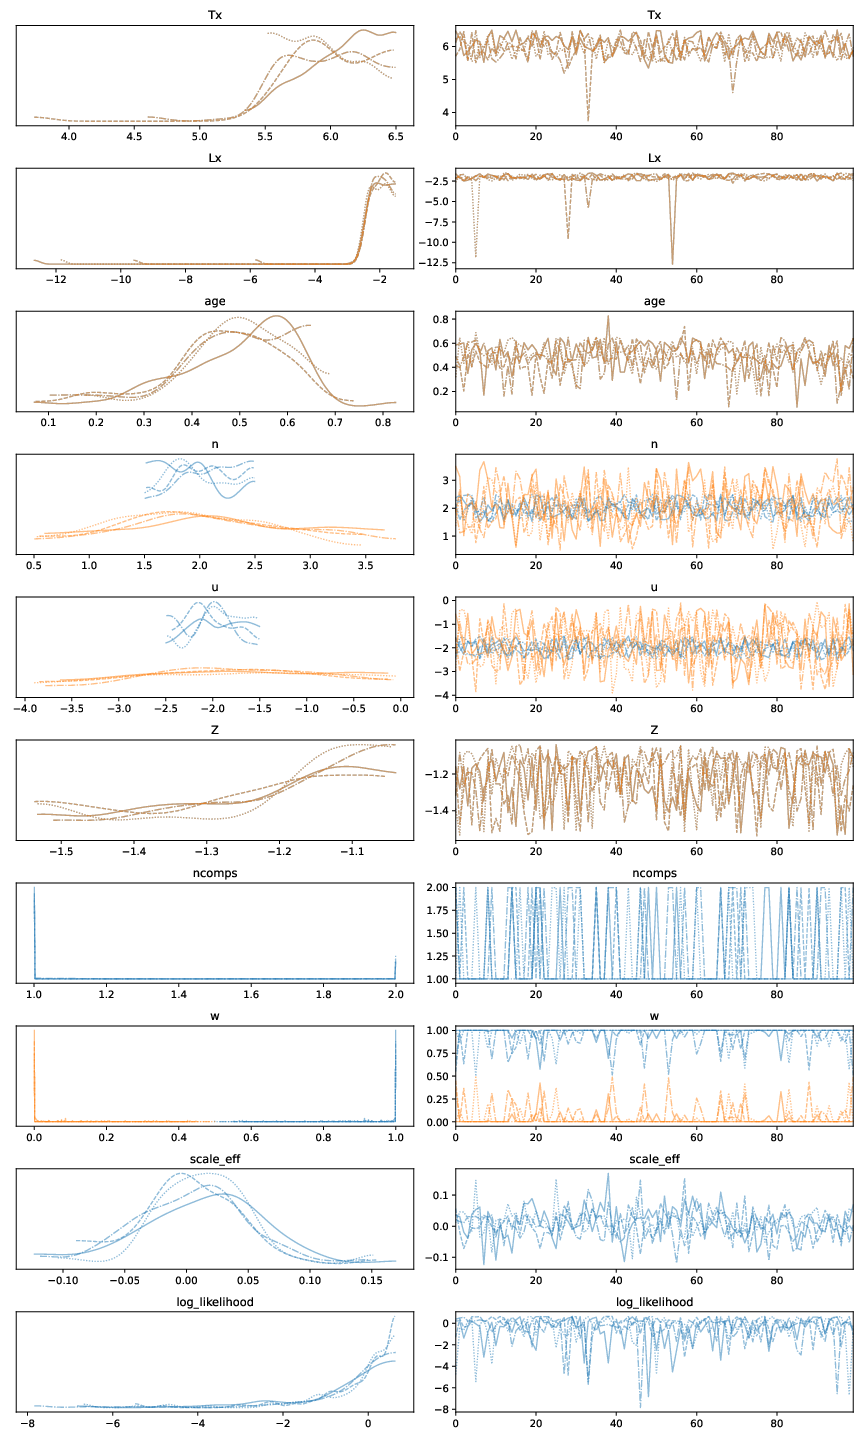

In [21]:
WImage(filename=output_directory+'Plots/Trace_params.pdf') 

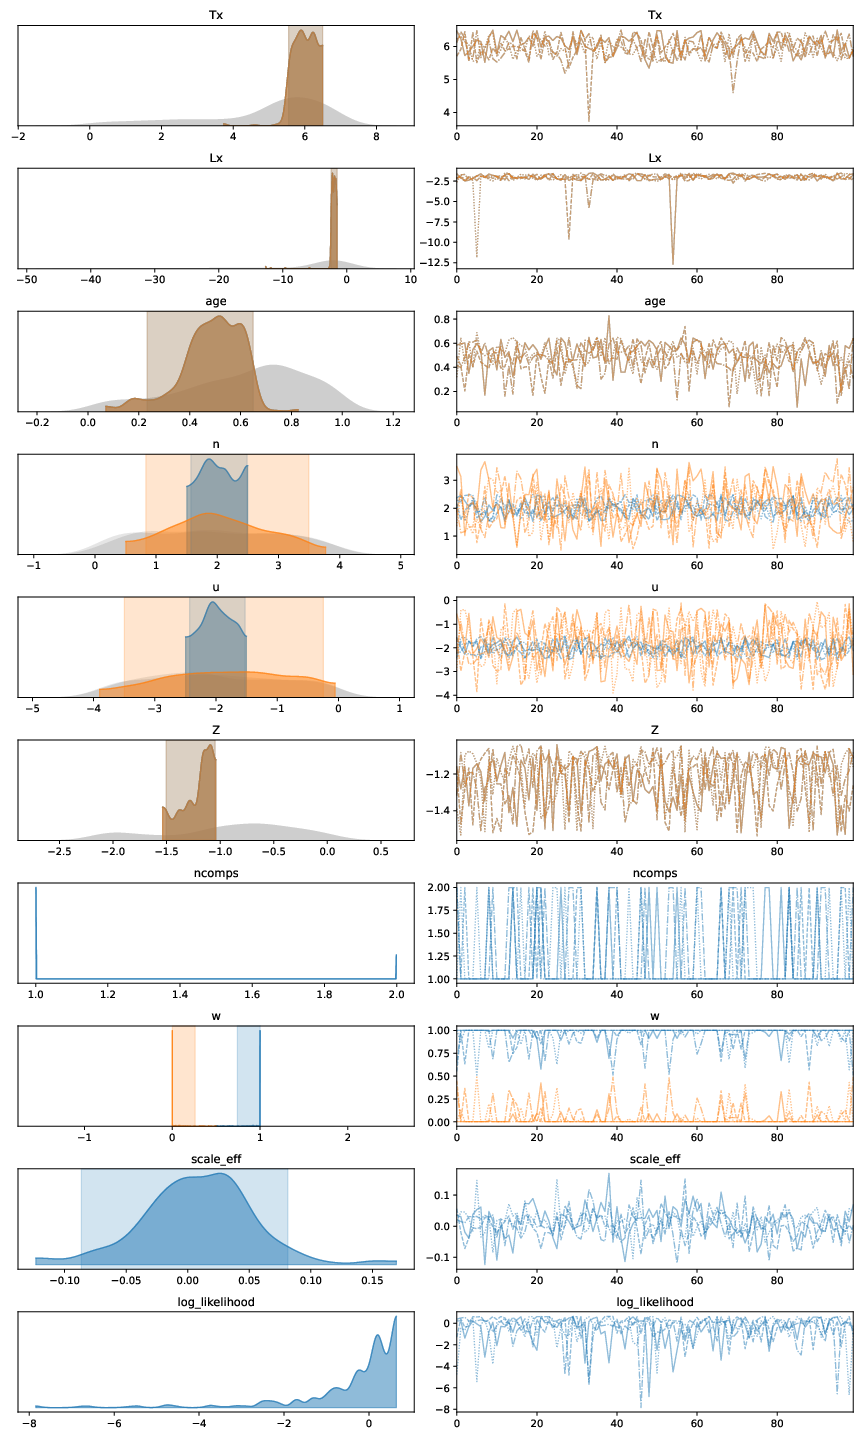

In [22]:
WImage(filename=output_directory+'Plots/Trace_params_combined.pdf') 

It is useful to compare the PDF for ncomps at different values: 

In [23]:
trace = az.from_netcdf(output_directory+'trace_process.netCDF')
trace.posterior['ncomps'].data.flatten()
tab = trace.posterior['ncomps'].data.flatten()
print(len(tab[tab==1]) / len(tab[tab==2]))

3.819277108433735


Here we can see that the solution with one component is strongly preferred. Let's make sure it's the case for all the jobs/chains:

In [24]:
# for each job/chain
for i in range(trace.posterior.dims['chain']):
    tmp = trace.posterior['ncomps'].data[i,:]
    print(len(tmp[tmp==1]) / len(tmp[tmp==2]))  

5.666666666666667
3.5454545454545454
4.2631578947368425
2.7037037037037037


### Test on real data

Test on real data shows that the trace for ignore_nsectors can be more difficult to interpret. 

Here we run an observation set of a galaxy from the Dwarf Galaxy Survey (Madden et al. [2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125..600M/abstract)). The model is not radiation-bounded anymore.

Since there are many random variables, we switch to GPU sampling (settings can be changed in the __rcParams__ file).

In [4]:
params = get_params()
params['context'].value = 'Contexts/mgris_sfgx'
output_directory = './Runs/ISM_applications/ncompsfree_realdata/'
params['output'].value = output_directory
params['USE configuration'].value = '1C2S'
params['select'].value = ['Z_dust [0,0]'] 
params['BEGIN observations'].value = '''O388.3323m 1.351e+039 1.323e+038
N357.3238m nan nan
N2121.767m nan nan
Ne315.5509m 5.13e+038 5.210e+037
Ne212.8101m <1.202e+037 nan
S410.5076m 1.182e+039 4.809e+037
S318.7078m 2.164e+038 4.008e+037
S333.4704m <1.924e+038 nan
C2157.636m 1.242e+038 3.206e+037
Si234.8046m <1.924e+038 nan
O425.8832m <7.214e+037 nan
Ar26.98337m <2.805e+037 nan
Ar38.98898m 7.214e+037 1.603e+037
Fe217.9314m <8.817e+037 nan
Fe225.9811m <7.214e+037 nan
Ar321.8253m <7.214e+037 nan
H112.3684m <6.412e+037 nan
N2205.244m nan nan
O163.1679m nan nan
O1145.495m nan nan
H217.0300m <6.012e+037 nan
H29.66228m <3.206e+037 nan
Ne514.3228m <6.813e+037 nan
Ne524.2065m <8.416e+037 nan
LTIR500.500m 2.164e+041 9.619e+039
Fe322.9190m <6.412e+037 nan
H228.2130m <8.016e+037 nan
H212.2752m <6.412e+037 nan'''
params['BEGIN observations'].extras = {'delta_add': 0.1, 'scale': 'linear'}
params['BEGIN configuration'].value = '''Z (0) = -0.99 0.11
n_comps_vary True'''
params['use_scaling'].value = "'all'"
make_input(params, inputfile)

In [5]:
if rcParams['inference_backend']=='gpu':
    nsamples_per_job = 150
else:
    nsamples_per_job = 100
    
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, order=0, nsamples_per_job=nsamples_per_job))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory

    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - 1a38371 (2024-09-06 08:20:37 +0200)
    ┝ - 1a38371
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805d

[23  3  8  5  5  8  4  4 17]
-> [23  1  8  5  5  8  4  4 17]
[23  1  8  5  5  8  4  4 17]


n 0: single value (nearest neighbor grid interpolation)


-> [23  1  1  5  5  8  4  4 17]
[23  1  1  5  5  8  4  4 17]


u 0: single value (nearest neighbor grid interpolation)


-> [23  1  1  1  5  8  4  4 17]
[23  1  1  1  5  8  4  4 17]


Z 0: single value (nearest neighbor grid interpolation)


-> [23  1  1  1  1  8  4  4 17]
[23  1  1  1  1  8  4  4 17]


Lx 0: single value (nearest neighbor grid interpolation)


-> [23  1  1  1  1  1  4  4 17]
[23  1  1  1  1  1  4  4 17]


Tx 0: single value (nearest neighbor grid interpolation)


-> [23  1  1  1  1  1  1  4 17]
[23  1  1  1  1  1  1  4 17]


cut 0: single value (nearest neighbor grid interpolation)


-> [23  1  1  1  1  1  1  1 17]
[23  1  1  1  1  1  1  1 17]


lum 1: single value (nearest neighbor grid interpolation)
age 1: single value (nearest neighbor grid interpolation)
n 1: single value (nearest neighbor grid interpolation)


-> [23  1  1  1  1  1  1  1  1]
[23  3  8  5  5  8  4  4 17]
-> [23  1  8  5  5  8  4  4 17]
[23  1  8  5  5  8  4  4 17]
-> [23  1  1  5  5  8  4  4 17]


u 1: single value (nearest neighbor grid interpolation)


[23  1  1  5  5  8  4  4 17]
-> [23  1  1  1  5  8  4  4 17]
[23  1  1  1  5  8  4  4 17]
-> [23  1  1  1  1  8  4  4 17]


Z 1: single value (nearest neighbor grid interpolation)


[23  1  1  1  1  8  4  4 17]


Lx 1: single value (nearest neighbor grid interpolation)


-> [23  1  1  1  1  1  4  4 17]
[23  1  1  1  1  1  4  4 17]


Tx 1: single value (nearest neighbor grid interpolation)


-> [23  1  1  1  1  1  1  4 17]
[23  1  1  1  1  1  1  4 17]


cut 1: single value (nearest neighbor grid interpolation)


-> [23  1  1  1  1  1  1  1 17]
[23  1  1  1  1  1  1  1 17]
-> [23  1  1  1  1  1  1  1  1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_cut_0, idx_cut_1, idx_lum_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, ncomps, scale, wtmp]
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_cut_0, idx_cut_1, idx_lum_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, ncomps, scale, wtmp]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                     mean        sd    hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
idx_Lx_0            1.522     0.789     0.115    2.804      0.034    0.025   
idx_Lx_1            1.522     0.789     0.115    2.804      0.034    0.025   
idx_Tx_0            1.500     0.817     0.258    2.996      0.037    0.026   
idx_Tx_1            1.500     0.817     0.258    2.996      0.037    0.026   
idx_Z_0             2.667     0.381     1.968    3.382      0.017    0.012   
idx_Z_1             2.667     0.381     1.968    3.382      0.017    0

initial particles...
build kernel...
start inference :  06/09/2024 20:29:43
end inference   :  06/09/2024 20:30:06
duration [min]  :  0.4
particles -> arviz...


100%|███████████████████████████████████████████████████████████████████| 150/150 [00:14<00:00, 10.35it/s]
Only the first 1000 were included in diagnosed quantities out of 31.
Sampler                : Blackjax SMC with HMC kernel
iterations             : 31
iterations to diagnose : 1000
MCMC steps             : 10
Step size              : 0.001

✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨


wrapping up...


Inference ended     : 2024-09-06 20:30:36.502382
Time used           : 2.7 min.
Sampling time used  :  0.38 min.
Garbage collection thresholds : (700, 10, 10)
Garbage collector: collected 374099 objects.

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ RESULTS AND VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


arviz - WARNING - Shape validation failed: input_shape: (1, 150), minimum_shape: (chains=2, draws=4)
                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
idx_Lx_0                  1.831  0.470   1.065    2.492      0.273    0.216   
idx_Lx_1                  1.831  0.470   1.065    2.492      0.273    0.216   
idx_Tx_0                  1.010  0.316   0.537    1.471      0.059    0.042   
idx_Tx_1                  1.010  0.316   0.537    1.471      0.059    0.042   
idx_Z_0                   2.447  0.340   1.853    3.065      0.204    0.163   
idx_Z_1                   2.447  0.340   1.853    3.065      0.204    0.163   
idx_age_0                 2.054  1.765   0.512   

In [6]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 20:30:38
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/ISM_applications/input.txt
    ┝ - output directory   : ./Runs/ISM_applications/ncompsfree_realdata/
    ┕=======================================

In [7]:
%cat $output_directory/results.txt


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
idx_Lx_0       2.071  0.309   1.561    2.481      0.029    0.021      99.0      86.0    NaN
idx_Lx_1       2.071  0.309   1.561    2.481      0.029    0.021      99.0      86.0    NaN
idx_Tx_0       0.963  0.330   0.537    1.425      0.038    0.027      52.0      41.0    NaN
idx_Tx_1       0.963  0.330   0.537    1.425      0.038    0.027      52.0      41.0    NaN
idx_Z_0        2.272  0.221   1.853    2.586      0.027    0.019      59.0      86.0    NaN
idx_Z_1        2.272  0.221   1.853    2.586      0.027    0.019      59.0      86.0    NaN
idx_age_0      1.126  0.680   0.512    1.447      0.075    0.053      71.0      86.0    NaN
idx_age_1      1.126  0.680   0.512    1.447      0.075    0.053      71.0      86.0    NaN
idx_cut_0      4.915  0.545   4.541    5.485      0.065    0.046      66.0      66.0    NaN
idx_cut_1     11.772  3.370   4.743   15.706      0.391    0.288      66.0     

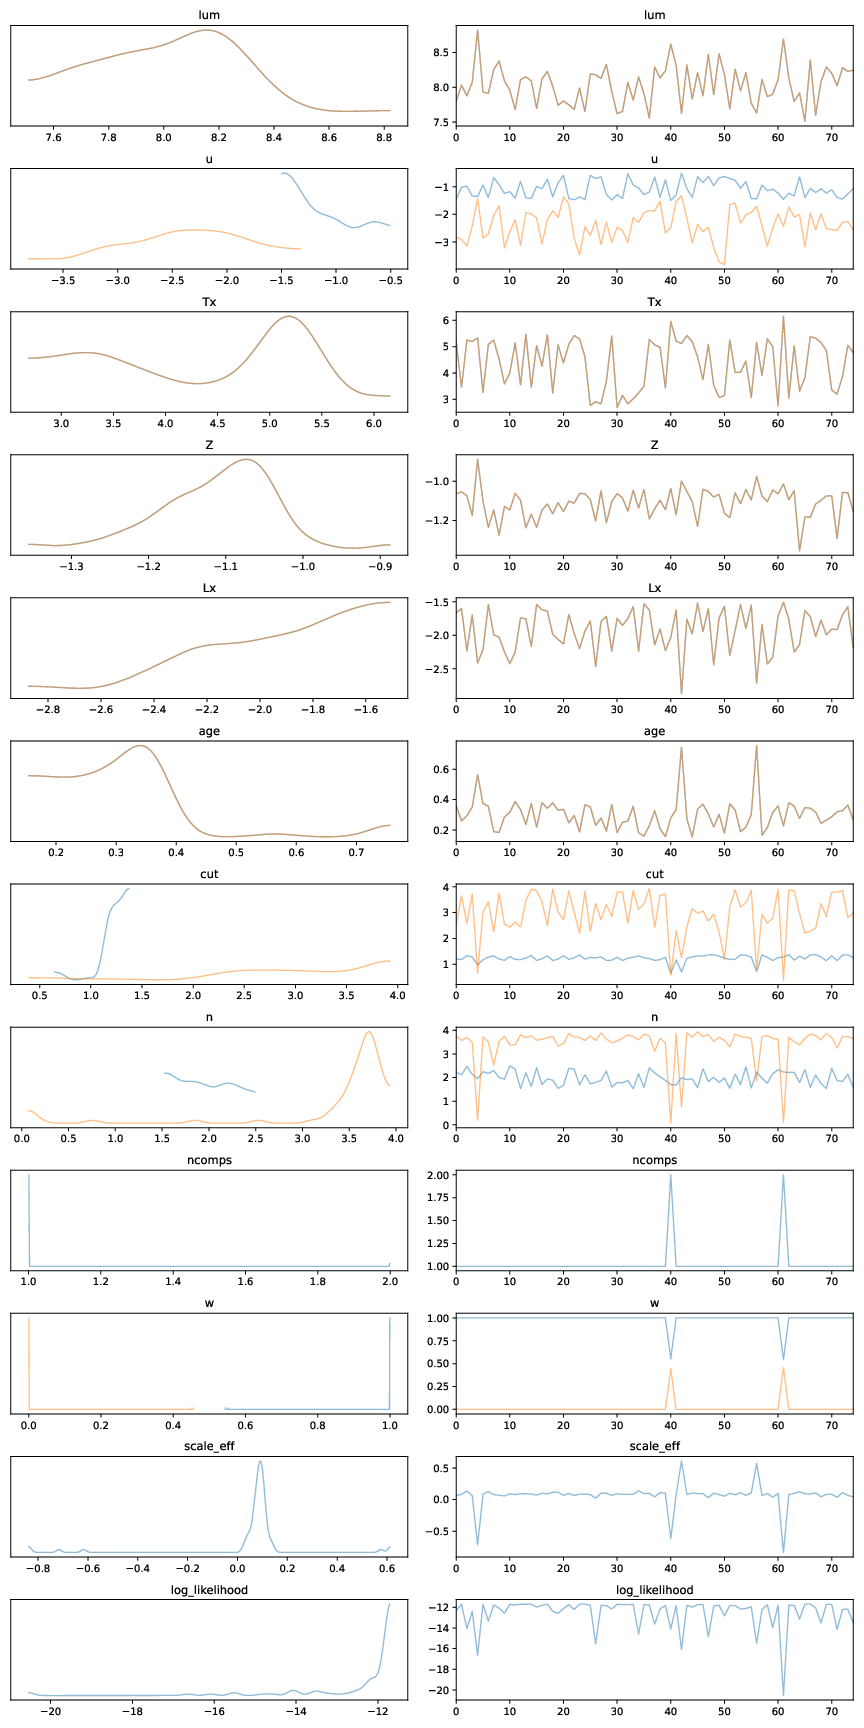

In [8]:
WImage(filename=output_directory+'Plots/Trace_params.pdf') 

It is useful to compare the PDF for ncomps at different values: 

In [9]:
trace = az.from_netcdf(output_directory+'trace_process.netCDF')
trace.posterior['ncomps'].data.flatten()
tab = trace.posterior['ncomps'].data.flatten()
print(len(tab[tab==1]) / len(tab[tab==2]))

36.5


In [10]:
# for each job/chain
for i in range(trace.posterior.dims['chain']):
    tmp = trace.posterior['ncomps'].data[i,:]
    print(len(tmp[tmp==1]) / len(tmp[tmp==2]))    

36.5


It must be noted that:
- the parameters for the second component are close to those for the first component, though with much wider PDFs, and
- the second component has a very small mixing weight

Note: do not use the mean value of ncomps, use the median or the mode. 

As for the model comparison with LOO, it may be useful to actually combine the predictions of each model with a given weight. 

### Full comparison <a class="anchor" id="app6c"></a>

The script mgris_compare can take the --ncomps argument to compare models with different number of components and also models where ncomps is varying. This option becomes really useful when models include ncomps varying with a different maximum number of components.

/!\ Model comparison is only meaningful if:
- the data is the same and observations defined the same way between the two models
- all chains have passed the burn-in phase and have converged (toward the same solution)
- there are significantly more observations than parameters


Run: ncompsplot



▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING MODEL: ./RUNS/ISM_APPLICATIONS/NCOMPS1 ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓



 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒
 ▒ - NCOMPS FIX = 1 ▒
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒


rhatmean = 1.001956898306309
Computed from 1000 posterior samples and 12 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -1.82     0.34
p_loo        0.62        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)        9   75.0%
   (0.67, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    3   25.0%

Computed from 1000 p

likelihood [-1.07420555 -1.37966539]
loo [-1.82120061 -2.37334698]
lml [-11.17923226 -13.66351315]
waic [-1.73213444 -2.26082914]
Average:
Average:


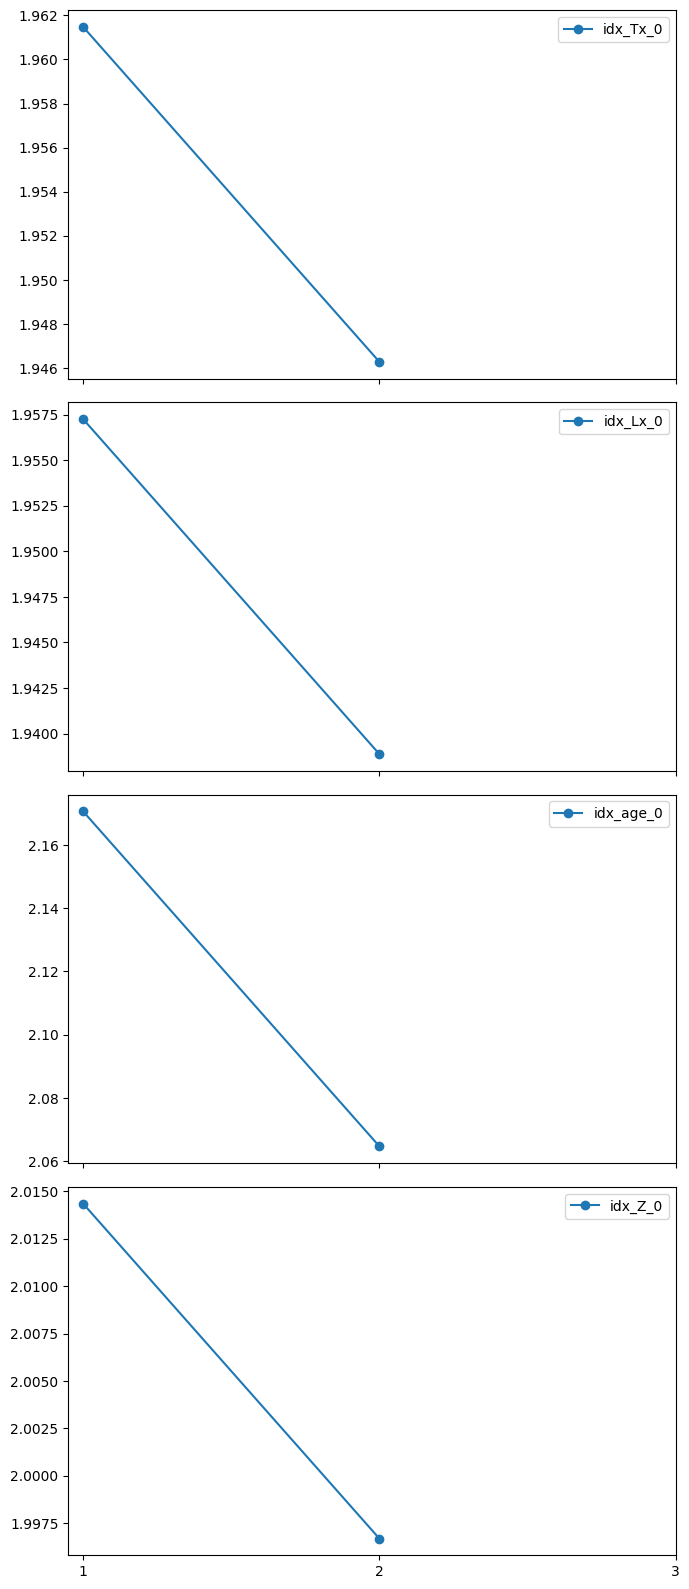

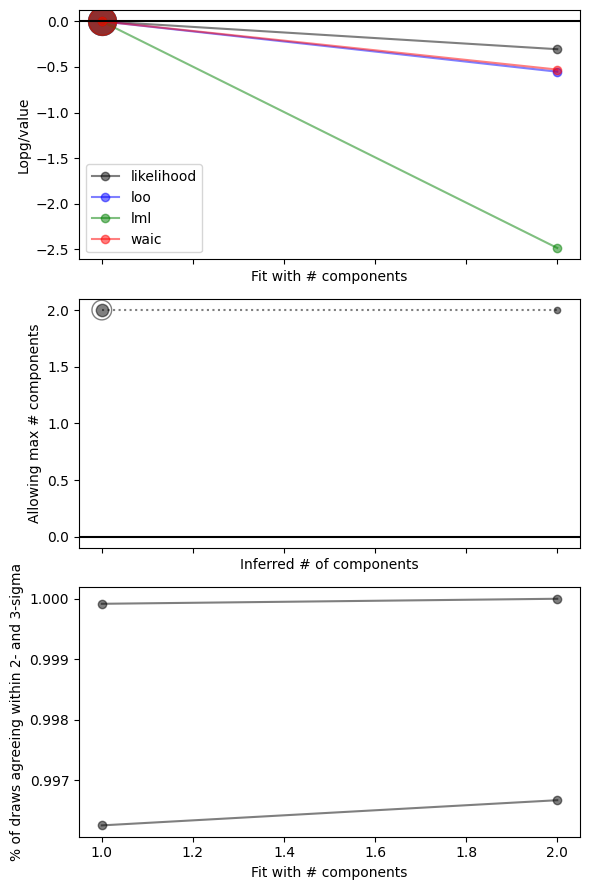

In [11]:
closelogfiles() #in case run was interrupted
mgris_compare.main(args=mgris_compare.args(ncomps=True, result_directories=['./Runs/ISM_applications/ncomps1/', './Runs/ISM_applications/ncomps2/', './Runs/ISM_applications/ncompsfree/'], output='ncompsplot'))

In [ ]:
WImage(filename='./ModelComparison//ncompsplot.pdf') 

- The likelihood is not very different between 1 and 2 components
- When allowing 2 components maximum, 2 is preferred
- When fitting with 1 or 2 components, the agreement is good within 2 and 3 sigma

Alternatively, it may be preferable to consider a statistical distribution of components instead of a high number of components (see power-law notebook)